In [4]:
import matplotlib.pyplot as plt
import datetime as datetime
import numpy as np
import pandas as pd
import talib
import seaborn as sns
from time import time
import pytz

In [5]:
import risk_model
import factorize
import account

In [13]:
availabe_accounts = pd.read_csv('account_ids.txt',header=None)
print (availabe_accounts.values)

[['DU1440139 ']
 ['U2909804']]


In [1]:
account_number = input("Enter your account id: ") 

Enter your account id: DU1440139


In [3]:
if account_number == availabe_accounts.values[0][1]:

    optimal_weights_regularized = pd.read_csv('output/optimal_weights_regularized_sa.csv',index_col = 'asset')
    close = pd.read_csv('data/close_sa.csv', index_col = 'date')
    
if account_number == availabe_accounts.values[0][0]:
    
    optimal_weights_regularized = pd.read_csv('output/optimal_weights_regularized.csv',index_col = 'asset')
    close = pd.read_csv('data/close.csv', index_col = 'date')

# 1 - Portfolio Management

In [5]:
portfolio = account.read_positions(subscribe = True, acctCode = account_number)

PositionEnd
Reading Portfolio


In [6]:
portfolio

,Position,marketPrice,marketValue,averageCost,unrealizedPNL,realizedPNL
Symbol,,,,,,
ACLS,32.0,27.887091,892.39,27.941250,-1.73,0.00
ALL,40.0,92.716705,3708.67,91.229290,59.50,0.00
AMD,18.0,69.313347,1247.64,69.835556,-9.40,0.00
CLF,-424.0,5.756000,-2440.54,5.798035,17.82,0.00
CWT,-50.0,49.281590,-2464.08,47.742484,-76.96,-57.24
DRQ,-44.0,34.254433,-1507.20,33.125510,-49.67,0.00
ETR,9.0,102.541855,922.88,97.876077,41.99,85.22
GTN,86.0,14.483999,1245.62,14.564065,-6.89,-16.49
MAC,49.0,8.193999,401.51,8.195000,-0.05,256.12


In [7]:
acc = account.read_account(reqId = 0, subscribe = True, acctCode = account_number)

AccountDownloadEnd. Account: U2909804
Reading Account


In [8]:
all_weights, long, short, grv = risk_model.portfolio_calculation(portfolio)

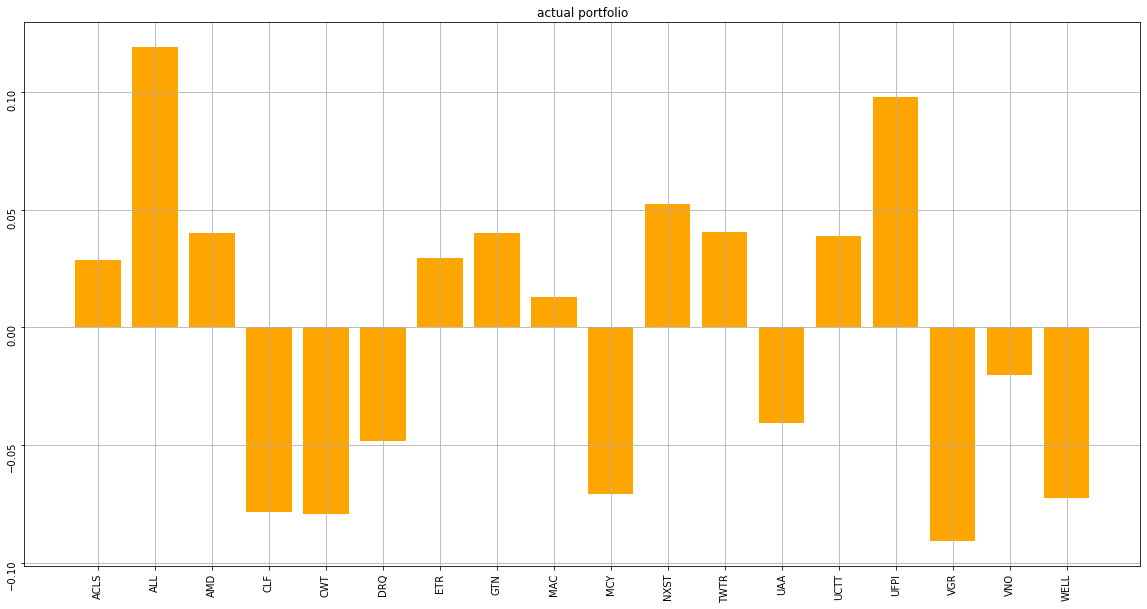

In [9]:
x = range(len(all_weights))
y = all_weights.values.flatten()
fig, ax = plt.subplots(figsize=(20, 10))
plt.grid(True)
plt.bar(x, y, width = 0.8, linewidth = 1, color='orange')
plt.xticks(x, tuple(all_weights.index))
plt.tick_params(labelrotation=90)
plt.title('actual portfolio')
plt.show()

In [10]:
long_value = long['marketValue'].sum()
short_value = short['marketValue'].sum()
#print ('Buying Power: {} $'.format(np.round(float(acc.loc['BuyingPower',:].values[0]), 4)))
print ('Gross Market Value: {} $'.format(np.round(grv, 4)))
print (' Long Value: {} $'.format(np.round(long_value,4)))
print (' Short Value: {} $'.format(np.round(short_value,4)))
print (' Net Liquidation: {} $'.format(np.round(float(acc.loc['EquityWithLoanValue',:].values[0]),4)))
print (' Unrealize PNL: {} $'.format(np.round(portfolio['unrealizedPNL'].sum()),4))
print (' Loan Value: {} $'.format(np.round(float(acc.loc['GrossPositionValue'][0]) - float(acc.loc['EquityWithLoanValue'][0]), 4)))
print ('#####################################')
print ('Leverage Value: {}'.format(np.round(grv/float(acc.loc['EquityWithLoanValue'][0]), 4)))
print (' Long Leverage Value: {}'.format(np.round(long_value/float(acc.loc['EquityWithLoanValue'][0]), 4)))
print (' Short Leverage Value: {}'.format(np.round(np.abs(short_value)/float(acc.loc['EquityWithLoanValue'][0]), 4)))       

Gross Market Value: 31176.94 $
 Long Value: 15585.88 $
 Short Value: -15591.06 $
 Net Liquidation: 20988.81 $
 Unrealize PNL: 387.0 $
 Loan Value: 10188.13 $
#####################################
Leverage Value: 1.4854
 Long Leverage Value: 0.7426
 Short Leverage Value: 0.7428


In [11]:
universe = portfolio.index
long_universe = long.index 
short_universe = short.index 

In [12]:
net_liq = np.round(float(acc.loc['EquityWithLoanValue',:].values[0]),4)

## 11 - 1 - Projected portfolio balance

In [13]:
target_leverage = 1.5
grv_target = net_liq * target_leverage
excess_grv = grv_target - grv
print (excess_grv,'$')
marketVal_target = all_weights * grv_target

306.27500000000873 $


In [14]:
balancing_order = marketVal_target['weights'] - portfolio['marketValue']
df_port = portfolio['marketPrice']
action_balance = pd.DataFrame(index = df_port.index, columns = ['shares'])
action_balance['shares'] = np.round(balancing_order / df_port,2)
to_drop = action_balance[action_balance['shares']==0.0].index
action_balance.drop(to_drop,axis=0,inplace=True)

In [15]:
grv_target

31483.215000000004

In [16]:
val = account.read_nextvalidid(reqId=-1)

NextValidId: 39


In [17]:
#account.rebalancing_to_leverage(action_balance = action_balance , order_id = val)

## 11 - 2 - Filtering stock with significant market value

In [18]:
df_c = pd.DataFrame(data=close[optimal_weights_regularized.index].iloc[-1].values,
                   index = close[optimal_weights_regularized.index].iloc[-1].index,
                   columns = ['close'])
df_c.index.name = 'asset'

In [19]:
optimal_weights_regularized = optimal_weights_regularized.round(2)

In [20]:
# dropping securities with less than 1% allocation 
optimal_selected = optimal_weights_regularized[optimal_weights_regularized['optimal_weights'] != 0.00]

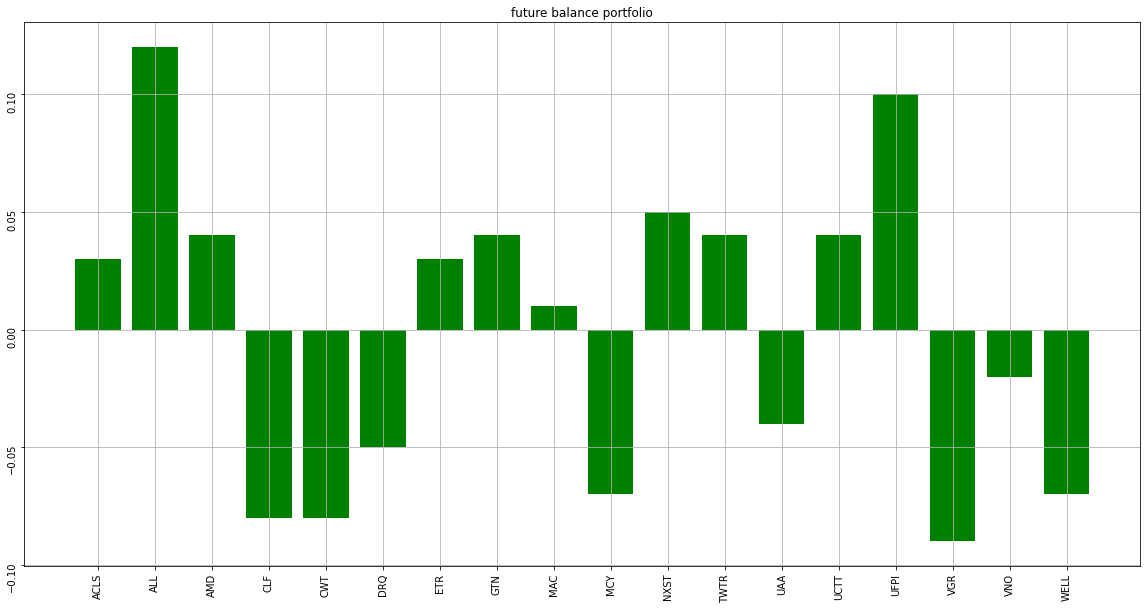

In [21]:
x = range(len(optimal_selected.sort_values(by='optimal_weights')))
y = optimal_selected.values.flatten()
fig, ax = plt.subplots(figsize=(20, 10))
plt.grid(True)
plt.bar(x, y, width = 0.8, linewidth = 1, color='green')
plt.xticks(x, tuple(optimal_selected.index))
plt.tick_params(labelrotation=90)
plt.title('future balance portfolio')
plt.show()

In [22]:
print ('##########################################################')
print ('dropping {} securities which have less than 1% allocation'.format(len(optimal_weights_regularized[optimal_weights_regularized['optimal_weights'] == 0.00].index)))
print ('##########################################################')

##########################################################
dropping 2 securities which have less than 1% allocation
##########################################################


## 11 - 4 - Processing data for execution

In [23]:
stock_to_balance = portfolio.index & optimal_selected.index
stock_to_close = portfolio.index ^ stock_to_balance

In [24]:
df_c_target = df_c.reindex(optimal_selected.index)
shares_target_float = (optimal_selected * grv_target)['optimal_weights']/df_c_target['close']

In [25]:
portfolio_shares_float = portfolio['marketValue'] / portfolio['marketPrice']

In [26]:
# Rebalance to optimal weights
action_final = pd.DataFrame(index = shares_target_float.index, columns = ['shares'])

for i in shares_target_float.index:
    
    if (i in stock_to_balance) and (i not in action_balance.index):
        action_final.loc[i,'shares'] = shares_target_float[i] - portfolio_shares_float[i]
        
    elif (i in stock_to_balance) and (i in action_balance.index):
        action_final.loc[i,'shares'] = shares_target_float[i] - (portfolio_shares_float[i] + action_balance['shares'][i])

    elif (i in action_balance.index) and (i not in stock_to_balance):
        action_final.loc[i,'shares'] = shares_target_float[i] + action_balance['shares'][i]
    else:
        action_final.loc[i,'shares'] = shares_target_float[i]

In [27]:
# rename columns
portfolio_shares_float = pd.DataFrame(portfolio_shares_float,columns = ['portfolio_shares'],index=portfolio_shares_float.index)
shares_target_float = pd.DataFrame(shares_target_float,columns = ['target_shares_not_balanced'],index=shares_target_float.index)


action_balance.columns = ['balance_lev_shares']
action_final.columns = ['final_action_shares']

In [28]:
# replacing too small actions value with nan value
treshold_long = 1
treshold_short = -1

action_final[(action_final['final_action_shares']>0) & (action_final['final_action_shares']< treshold_long)] = np.nan
action_final[(action_final['final_action_shares']<0) & (action_final['final_action_shares']> treshold_short)] = np.nan
action_final[action_final['final_action_shares']==0.0] = np.nan
action_final.dropna(axis=0,inplace=True)
action_final['final_action_shares'] = pd.to_numeric(action_final['final_action_shares'], errors='coerce')

In [29]:
action_conc = pd.concat([portfolio_shares_float,
                         action_balance,
                         shares_target_float,
                         action_final],axis=1)

In [30]:
isna_df = action_conc.isna()
for i in action_conc.index:
    if (isna_df.loc[i]['final_action_shares'] == True) & (isna_df.loc[i]['target_shares_not_balanced'] == False) :
        action_conc.drop(i, inplace = True)

In [31]:
action_conc.round(2)

,portfolio_shares,balance_lev_shares,target_shares_not_balanced,final_action_shares
ACLS,32.0,2.87,32.78,-2.09
ALL,40.0,3.56,40.76,-2.80
AMD,18.0,1.60,18.26,-1.34
CLF,-424.0,-38.10,-427.66,34.44
CWT,-50.0,-4.49,-51.15,3.34
DRQ,-44.0,-3.89,-44.95,2.94
GTN,86.0,7.59,89.13,-4.46
MAC,49.0,4.53,39.96,-13.57
MCY,-53.0,-4.71,-53.28,4.43
NXST,19.0,1.70,18.70,-2.00


## 11 - 5 - Executing on TWS

In [32]:
op = account.cancel_openorders()

open order ended


In [36]:
# closing positions not in shares target
if not stock_to_close.empty:
    next_order_id = account.closing_positions(stock_to_close = stock_to_close,
                                              portfolio = portfolio , 
                                              order_id = val)
else:
    print ('There is not stock to close...')
    next_order_id = val

app is running ...
closing 5 positions which are not present in action
closing position for ALTR is: 25 
closing position for CBRE is: 61 
closing position for FLOW is: 16 
closing position for PEB is: 155 
closing position for PK is: 32 


In [37]:
action_final = action_final.astype('int')
account.placing_final_orders(action_final=action_final, order_id = next_order_id)

buy order quantity placed for ACLS is: 32 
buy order quantity placed for ALL is: 4 
buy order quantity placed for AMD is: 18 
sell order quantity placed for CLF is: 249 
buy order quantity placed for CWT is: 32 
sell order quantity placed for DRQ is: 30 
sell order quantity placed for ETR is: 17 
sell order quantity placed for GTN is: 76 
buy order quantity placed for MAC is: 503 
sell order quantity placed for MCY is: 52 
sell order quantity placed for NXST is: 6 
buy order quantity placed for TWTR is: 34 
sell order quantity placed for UAA is: 112 
buy order quantity placed for UCTT is: 51 
buy order quantity placed for UFPI is: 9 
sell order quantity placed for VGR is: 38 
sell order quantity placed for VNO is: 18 
sell order quantity placed for WELL is: 43 


In [38]:
open_orders_all = account.get_openorders()

open order ended


In [39]:
open_orders_all

,action,executed_orders,type,algoStrategy,algoParams,status


In [40]:
not_executed_action = open_orders_all.index ^ action_conc.index                        
print ('{} not executed'.format(list(not_executed_action)))

['ACLS', 'ALL', 'ALTR', 'AMD', 'CBRE', 'CLF', 'CWT', 'DRQ', 'ETR', 'FLOW', 'GTN', 'MAC', 'MCY', 'NXST', 'PEB', 'PK', 'TWTR', 'UAA', 'UCTT', 'UFPI', 'VGR', 'VNO', 'WELL'] not executed


In [42]:
execution = pd.concat([action_conc, open_orders_all[['executed_orders']]],axis=1)

In [43]:
execution

,portfolio_shares,balance_lev_shares,target_shares_not_balanced,final_action_shares,executed_orders
ACLS,NaN,NaN,32.798473,32.798473,NaN
ALL,36.000015,0.77,40.787573,4.017558,NaN
ALTR,-24.999915,-0.50,NaN,NaN,NaN
AMD,NaN,NaN,18.273684,18.273684,NaN
CBRE,61.000033,1.34,NaN,NaN,NaN
CLF,-175.000000,-3.57,-427.957895,-249.387895,NaN
CWT,-82.000043,-1.76,-51.181157,32.578885,NaN
DRQ,-14.000072,-0.29,-44.986294,-30.696222,NaN
ETR,26.000042,0.55,9.291772,-17.258269,NaN
FLOW,-16.000058,-0.36,NaN,NaN,NaN


## 11 - 6 - Commission report of last realized trades

In [22]:
df = account.commission_report(acctCode = account_number, time= '20200701')

In [25]:
execution_date = '2020-07-28'

In [23]:
df

,ticker,shares,action,price,marketValue,RealizedPNL,commission
time,,,,,,,
2020-07-28 11:32:44,FLOW,16,BOT,39.61,633.76,-15.9834,1
2020-07-28 11:32:48,PEB,100,BOT,10.21,1021,116.952,1
2020-07-28 11:32:48,PEB,55,BOT,10.21,561.55,64.8734,0
2020-07-28 11:32:56,CBRE,61,SLD,42.68,2603.48,-134.148,1.0648
2020-07-28 11:33:01,PK,32,SLD,8.29,265.28,-48.7091,1.00967
2020-07-28 11:33:07,ALTR,25,BOT,39.11,977.75,-51.0932,1
2020-07-28 11:33:18,AMD,18,BOT,69.78,1256.04,OPEN,1
2020-07-28 11:33:18,CWT,32,BOT,49.5,1584,-57.2405,1
2020-07-28 11:33:19,UFPI,9,BOT,57.65,518.85,OPEN,1


In [26]:
RealizedPNL = np.round(pd.to_numeric(df.loc[slice(execution_date)]['RealizedPNL'], errors='coerce').sum(),2)
#Total_Realized_Return = np.round((RealizedPNL/net_liq)*100,2)
print ('Report for {}:'.format(execution_date))
print (' Market Value: {} $'.format(np.round(df.loc[slice(execution_date)]['marketValue'].sum(),2)))
print (' Total Commission: {} $'.format(np.round(df.loc[slice(execution_date)]['commission'].sum(),2)))
print (' Total Realized PNL: {} $'.format(RealizedPNL))  
#print (' Total Realized Return: {} %'.format(Total_Realized_Return))  


Report for 2020-07-28:
 Market Value: 29738.46 $
 Total Commission: 25.19 $
 Total Realized PNL: 199.49 $
